In [1]:
import os
from _ast import mod

import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.utils.tensorboard import SummaryWriter

from train import ModelManager, DIR_ROOT_SAVE, DIR_ROOT_LOG
from utils import get_loader, get_cifar10
import matplotlib.pyplot as plt

# globals
NUM_CLASSES = 10
BATCH_SIZE = 25
NUM_TRAIN = 50000
NUM_TEST = 10000
EPOCHS = 60

NOTEBOOK_NAME = 'prune_10_70_p_cifar10'
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')
PATH_KMEANS = os.path.join(DIR_ROOT_SAVE, 'k_means', 'cifar10.pt')
PATH_LOG = os.path.join(DIR_ROOT_LOG, NOTEBOOK_NAME, 'test_acc.pt')

print('train on:', ModelManager.DEVICE)

train_idx = np.arange(NUM_TRAIN, dtype=int)
test_idx = np.arange(NUM_TEST, dtype=int)
dataset_train, dataset_test, dataset_train_for_test, dataset_train_raw = get_cifar10()
# loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
loader_test = get_loader(dataset_test, test_idx, BATCH_SIZE, shuffle=False)
loader_train_ordered = get_loader(dataset_train_for_test, train_idx, BATCH_SIZE, shuffle=False)
Y_train = Tensor(dataset_train.targets)[train_idx].type(torch.int64)
Y_test = Tensor(dataset_test.targets)[test_idx].type(torch.int64)

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km = np.load(os.path.join(DIR_ROOT_SAVE, 'swav_cifar10_512', 'km_dist.npy'))

# forgetting_model = ModelManager(NUM_CLASSES, 'forgetting', load=True)
# change_counter = forgetting_model.data_other['change_counter']
#
# ensemble_softmax = torch.arange(NUM_TRAIN)
# ensemble_pred = torch.arange(NUM_TRAIN)
# ensemble_pred_sum = torch.arange(NUM_TRAIN)
# # ensemble_std =  torch.arange(NUM_TRAIN)
# el2n_scores = torch.arange(NUM_TRAIN)
# change_counter = torch.arange(NUM_TRAIN)

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_sorted_km = np.argsort(km)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_forgetting, 'forget': idx_true_forget,
              'km': idx_sorted_km}
# idx_sorted

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy(),
    'km': km
})
data.corr()

train on: cuda
Files already downloaded and verified
Files already downloaded and verified


,EL2N,Std,True p sum,flip,forget,k-1000,k-100
EL2N,1.000000,0.780107,-0.944299,0.658627,0.399751,0.136638,0.115659
Std,0.780107,1.000000,-0.660269,0.586532,0.377763,0.140598,0.123509
True p sum,-0.944299,-0.660269,1.000000,-0.627331,-0.350162,-0.113160,-0.093674
flip,0.658627,0.586532,-0.627331,1.000000,0.770378,0.101815,0.085754
forget,0.399751,0.377763,-0.350162,0.770378,1.000000,0.080567,0.070020
k-1000,0.136638,0.140598,-0.113160,0.101815,0.080567,1.000000,0.920600
k-100,0.115659,0.123509,-0.093674,0.085754,0.070020,0.920600,1.000000


In [2]:
no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=True)
# loader_train = get_loader(dataset_train, train_idx, BATCH_SIZE, shuffle=True)
# no_prune.train(loader_train, loader_test, loader_test, EPOCHS)
# models = [no_prune]
prune_sizes = [.1, .2, .3, .4, .5, .6, .7]

acc_test: dict[str:dict[float:float]] = {'no_prune': {p: no_prune.data['test']['acc'] for p in prune_sizes}}

print()
for name, idx in idx_sorted.items():
    acc_test[name] = {}
    for prune_size in prune_sizes:
        print(f'====     train model with {prune_size:.0%} prune according to {name} most hard     ======')

        if name == 'km':
            num_train = int(NUM_TRAIN * (1. - prune_size))
            # print(name, idx[-num_train:])
            loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, True)
            model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_{int(prune_size * 100)}p', dir_=NOTEBOOK_NAME,
                                         load=False)
            model_manager.train(loader_train, loader_test, loader_test, EPOCHS)
        else:
            model_manager = ModelManager(NUM_CLASSES, model_name=f'{name}_{int(prune_size * 100)}p', dir_=NOTEBOOK_NAME,
                                         load=True)

        acc_test[name][prune_size] = model_manager.data['test']['acc']
        print()


====     train model with 10% prune according to random most hard     ======

====     train model with 20% prune according to random most hard     ======

====     train model with 30% prune according to random most hard     ======

====     train model with 40% prune according to random most hard     ======

====     train model with 50% prune according to random most hard     ======

====     train model with 60% prune according to random most hard     ======

====     train model with 70% prune according to random most hard     ======

====     train model with 10% prune according to el2n most hard     ======

====     train model with 20% prune according to el2n most hard     ======

====     train model with 30% prune according to el2n most hard     ======

====     train model with 40% prune according to el2n most hard     ======

====     train model with 50% prune according to el2n most hard     ======

====     train model with 60% prune according to el2n most hard     =====

In [5]:
acc_test.keys()

dict_keys(['no_prune', 'random', 'el2n', 'std', 'pred_sum', 'flip', 'forget', 'k-1000', 'k-100'])

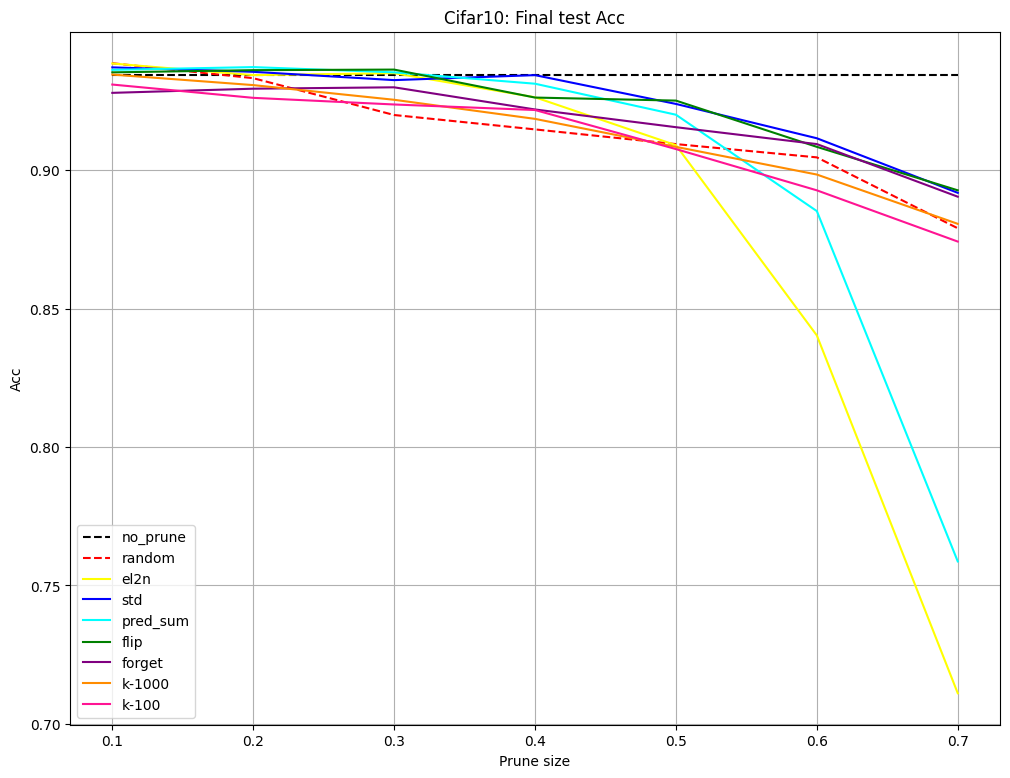

In [3]:
plt.figure(figsize=(12, 9))

colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple', 'darkorange', 'deeppink')
#          no       rand    el2n     std     sum     flip      forget      km      k-1000

markers = ('dashed', 'solid')
for i, prune_method in enumerate(acc_test):
    plt.plot(prune_sizes, [acc_test[prune_method][p] for p in prune_sizes], label=prune_method,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower left')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()

In [ ]:
import pickle

with open('cifar10_10_70', 'wb') as f:
    pickle.dump(acc_test, f)